# Starbucks Offers Optimization

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Data-Understanding" data-toc-modified-id="Data-Understanding-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Understanding</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data Analysis</a></span></li></ul></li><li><span><a href="#Modelling-and-Evaluation" data-toc-modified-id="Modelling-and-Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modelling and Evaluation</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

We will combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. Informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, we can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

There is transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

We will combine these datasets to build a model to predict if a customer is likely to respond to a particular offer.

We don't want to send offers to customers who are not likely to respond as there is cost associated with sending the offers. Also, we don't want to miss out on sending offers to customers who are likely to respond. 


# Data Understanding

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
# import standard packages
import warnings
import pandas as pd
import numpy as np
import math
import json
from time import time

# Data cleaning
from sklearn.feature_extraction.text import CountVectorizer
from pandas.io.json import json_normalize

# Show progress for data processing
from progressbar import *

# Modeling
from sklearn.metrics import classification_report, f1_score, accuracy_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

# Feature importance
from eli5.sklearn import PermutationImportance
import eli5

# Model Explaination
import lime.lime_tabular

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')  # sets the visualization style
%matplotlib inline

# Set some defaults
warnings.filterwarnings("ignore")

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
# check the dataset size
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

Take a look at the first few rows of the dataset


In [4]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [5]:
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [6]:
transcript.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


Id columns in the data set are not in user friendly formats.

In [7]:
print('There are {} offers and {} customers in the dataset'.format(
    portfolio.id.nunique(), profile.id.nunique()))

There are 10 offers and 17000 customers in the dataset


In [8]:
print('The validity period of the offers ranges from {} to {} days'.format(
    portfolio.duration.min(), portfolio.duration.max()))

The validity period of the offers ranges from 3 to 10 days


In [9]:
print('The difficulty level of the offers ranges from {} to {}'.format(
    portfolio.difficulty.min(), portfolio.difficulty.max()))

The difficulty level of the offers ranges from 0 to 20


In [10]:
print('The transcript dataset has transactions data  for {} days'.format(
    round((transcript.time.max() - transcript.time.min())/24), 0))

The transcript dataset has transactions data  for 30 days


In [11]:
profile.became_member_on.min(), profile.became_member_on.max()

(20130729, 20180726)

 The latest membership registration was on July of 2018 suggesting the data is 1 year old.

# Data Preparation

## Data Cleaning

For each of the dataset we will assess the inconsistencies and characteristics of the data and then we will address all of these together using a cleaning function.

From the data understanding phase , we know customer Id and offer Id columns in the data set are not in user friendly formats. We will convert these to more legible format by using a common mapper function.

In [12]:
def id_mapper(df):
    '''
    Mapper function to map unique integer ids to customers and offers

    INPUT:
    df - a dataframe holding the 'id' variable

    OUTPUT:
    coded_dict - a dictionary with original and encoded id values
    '''
    coded_dict = dict()
    counter = 1

    for val in df['id']:
        if val not in coded_dict:
            coded_dict[val] = counter
            counter += 1

    return coded_dict

**portfolio**

In [13]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


Claning steps:

*    Map unique integer ids to each offer.

*    Split the channels into separate columns.

*    Remove the common email channel.


In [14]:
def clean_portfolio(df):
    '''
    Cleans portfolio data using the following steps. 

    INPUT:
    df - a dataframe holding all the variables of interest

    OUTPUT:
    df - a dataframe with missing values columns dropped
    offer_id_encoded - a dictionary with original and encoded offer id values
    '''
    offer_id_encoded = id_mapper(portfolio)
    df['offer_id'] = df['id'].map(offer_id_encoded)
    df.channels = df.channels.astype(
        'str').str.replace(
        "[", "").str.replace(
        ']', "").str.replace(
        ' ', "").str.replace(
        "'", "")
    count_vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','))
    channels = count_vectorizer.fit_transform(df.channels)
    df_channels = pd.DataFrame(
        channels.toarray(), columns=count_vectorizer.get_feature_names())
    df_channels = df_channels.drop(["email"], axis=1)

    df = pd.concat([df, df_channels], axis=1)

    df = df.drop(['id', 'channels'], axis=1)

    return df, offer_id_encoded

In [15]:
# No of rows and columns before cleaning
portfolio.shape

(10, 6)

In [16]:
# Clean portfolio data
portfolio, offer_id_encoded = clean_portfolio(portfolio)

In [17]:
# No of rows and columns after cleaning
portfolio.shape

(10, 8)

In [18]:
#Take a peek at the cleaned portfolio data
portfolio.head(2)

,reward,difficulty,duration,offer_type,offer_id,mobile,social,web
0,10,10,7,bogo,1,1,1,0
1,10,10,5,bogo,2,1,1,1


**profile**

In [19]:
# Check data types
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


Became_member_on is not in date format. We will use this column to create a new column to reflect membership duration for each of the users. We will take the most recent date from 'became member on' as the reference date for calculating membership duration.

In [20]:
# Check for missing values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [21]:
profile[profile.gender.isnull()].age.unique()

array([118], dtype=int64)

In [22]:
profile[profile.income.isnull()].age.unique()

array([118], dtype=int64)

2175 users have missing income and gender data.
All of these users seem to have age 118. 
We will remove these users since people with 118 years of age is very uncommon and it seems the missing values for age is filled with 118 by defaullt.

In [23]:
style.use('seaborn-poster')  # sets the size of the charts

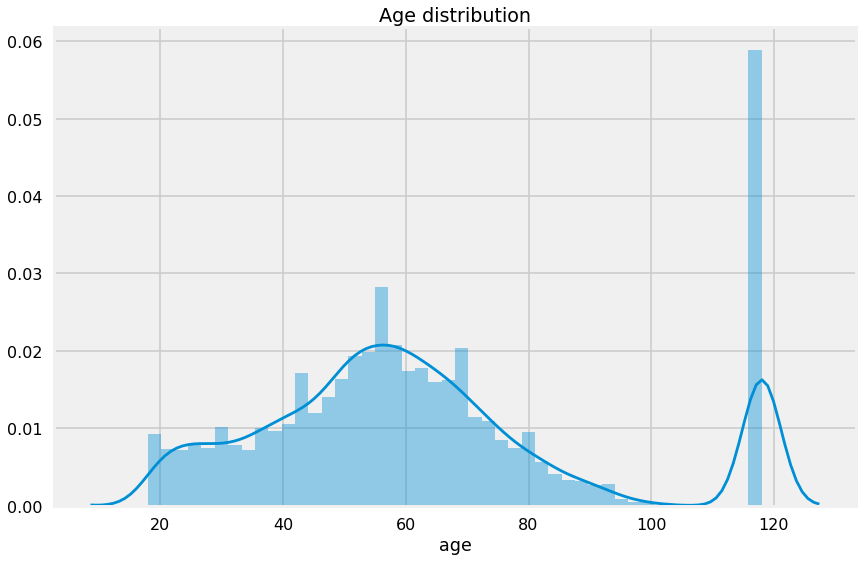

In [24]:
sns.distplot(profile.age)
plt.title('Age distribution')
plt.show()

Apart from the one anomaly, the age seems to be normally distributed.

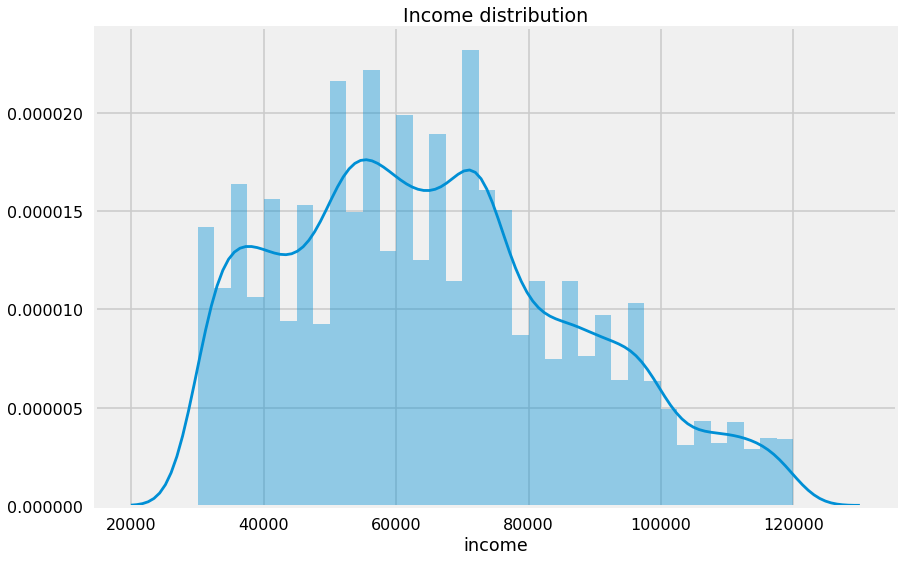

In [25]:
sns.distplot(profile.income.dropna())
plt.title('Income distribution')
plt.show()

The income data is slightly skewed towards the right. However, it's a near normal distribution. 

Cleaning Steps:

*  Map unique integer ids to each person
*  Remove the profiles for the persons aged 118 years
*  Convert 'become member on' to date format
*  Create new column 'membership_duration' based on 'become member on' column 
*  drop 'become member on' column 

In [26]:
def clean_profile(df):
    '''
    Cleans profile data

    INPUT:
    df - a dataframe holding all the variables of interest

    OUTPUT:
    df - a dataframe with missing values columns dropped
    cust_id_encoded - a dictionary with original and encoded customer id values
    '''
    cust_id_encoded = id_mapper(profile)
    df['cust_id'] = df['id'].map(cust_id_encoded)
    df = df.drop('id', axis=1)
    df = df[df.age != 118]

    df.became_member_on = pd.to_datetime(df.became_member_on, format='%Y%m%d')
    df['membership_duration'] = df.became_member_on.max() - \
        df['became_member_on']
    df['membership_duration'] = df['membership_duration'].apply(
        lambda x: x.days if x is not np.nan else x)

    df = df.drop('became_member_on', axis=1)

    return df, cust_id_encoded

In [27]:
# No of rows and column before cleaning
profile.shape

(17000, 5)

In [28]:
# Clean profile data
profile, cust_id_encoded = clean_profile(profile)

In [29]:
# No of rows and columns after cleaning
profile.shape

(14825, 5)

In [30]:
# Take a peek at cleaned profile data
profile.head(2)

,gender,age,income,cust_id,membership_duration
1,F,55,112000.0,2,376
3,F,75,100000.0,4,443


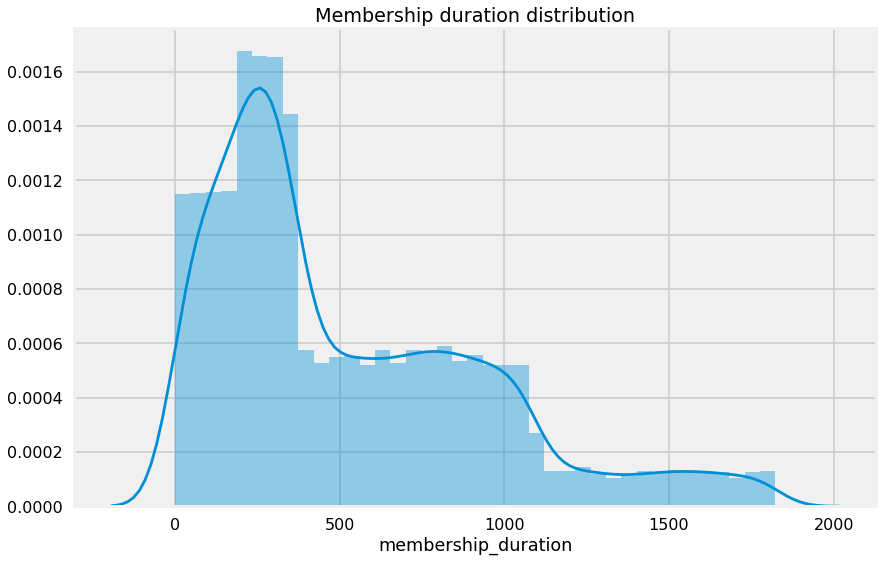

In [31]:
sns.distplot(profile.membership_duration)
plt.title('Membership duration distribution')
plt.show()

**transcript**

In [32]:
# Check for missing values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [33]:
transcript.sample(3)

,person,event,value,time
282196,94de646f7b6041228ca7dec82adb97d2,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},624
259641,4e3fa85725f141f6b4bf3bae3a485986,transaction,{'amount': 3.79},576
72577,cb55460bf6ac4dc8b4c48623f061544c,transaction,{'amount': 6.16},180


The values column has both 'offer id' and 'offer_id' verbiages. These need to be consolidated under a single 'offer_id' column. Also, since the offer duration is in days , we will convert the time column to days

In [34]:
def clean_values(row):
    '''
    Consolidates the offer_id and offer id values under a single column
    INPUT:
    df - a dataframe holding all the variables of interes
    OUTPUT:
    df - a dataframe with missing values columns dropped
    cust_id_encoded - a dictionary with original and encoded customer id values
    '''
    if pd.isna(row['offer_id']):
        return row['offer id']
    else:
        return row['offer_id']

Claning steps:

*    Map unique integer ids to each person and offer using the id mapping dictionaries used in cleaning profile and portfolio data
*    Extract amounts ,offer ids and rewards from value column
*    Covert time from hours to days
*    Split the transcript data frame into two separate dataframes containing transactions and non-transactions data respectively.


In [35]:
def clean_transcript(df, cust_id_encoded, offer_id_encoded):
    '''
    Cleans transcript data

    INPUT:
    df - a dataframe holding all the variables of interest

    OUTPUT:
    df - a dataframe with missing values columns dropped
    cust_id_encoded - a dictionary with original and encoded customer id values
    '''
    df_values = json_normalize(df['value'])
    df_values['offer_id'] = df_values[[
        'offer id', 'offer_id']].apply(clean_values, axis=1)
    df_values = df_values.drop('offer id', axis=1)
    df = pd.concat([df, df_values], axis=1, )
    df.time = df.time/24

    df['cust_id'] = df['person'].map(cust_id_encoded)
    df['offer_id'] = df['offer_id'].map(offer_id_encoded)

    df = df.drop(['value', 'person'], axis=1)

    # We will fill up the null values for amount, offer_id and reward with zeroes
    df['amount'].fillna(0, inplace=True)
    df['offer_id'].fillna(0, inplace=True)
    df['reward'].fillna(0, inplace=True)

    trans_df = df[df.event == 'transaction'].sort_values(
        by='time').drop(['offer_id'], axis=1)
    non_trans_df = df[df.event != 'transaction'].drop(
        ['amount', 'reward'], axis=1).sort_values(by='time')

    return df, trans_df, non_trans_df

In [36]:
# No of rows and columns before cleaning
transcript.shape

(306534, 4)

In [37]:
# Cleans transcript data
transcript, transactions, non_transactions = clean_transcript(
    transcript, cust_id_encoded, offer_id_encoded)

In [38]:
# No of rows and columns after cleaning
transcript.shape

(306534, 6)

In [39]:
# Take a peek at cleaned transcript data
transcript.sample(4)

,event,time,amount,offer_id,reward,cust_id
222080,transaction,21.50,1.39,0.0,0.0,1069
62447,offer received,7.00,0.00,7.0,0.0,12542
263546,transaction,24.25,5.32,0.0,0.0,7177
60035,offer received,7.00,0.00,9.0,0.0,16077


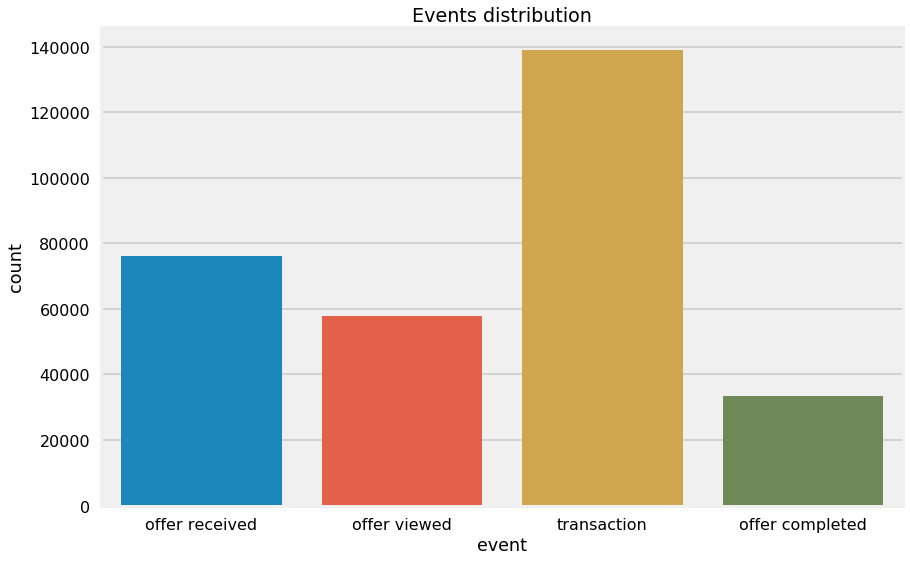

In [40]:
# Plot events distribution
sns.countplot(transcript.event)
plt.title('Events distribution')
plt.show()

This seems to be per expectation. Not all offers that were received, were viewed and completed.

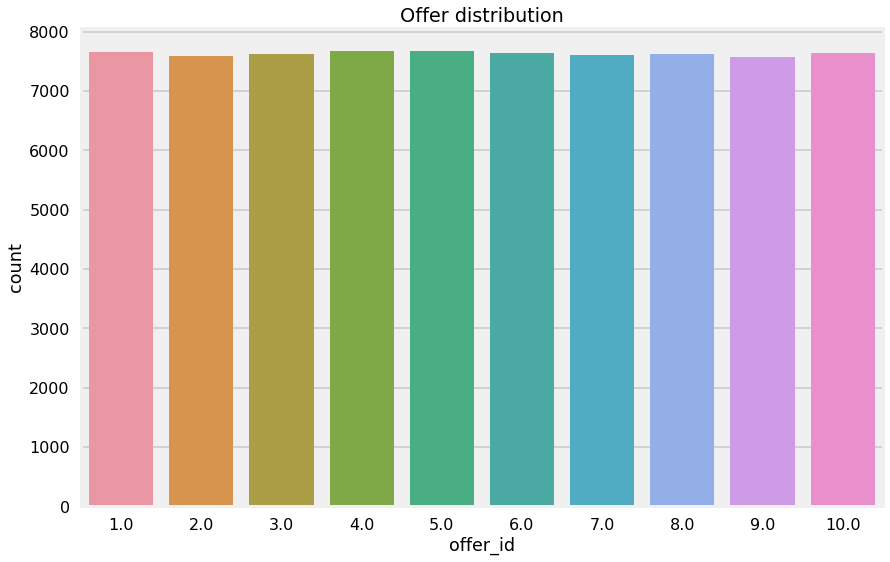

In [41]:
# Plot offers distribution
sns.countplot(
    non_transactions[non_transactions.event == 'offer received'].offer_id)
plt.title('Offer distribution')
plt.show()

All the offers were sent almost equal number of times.

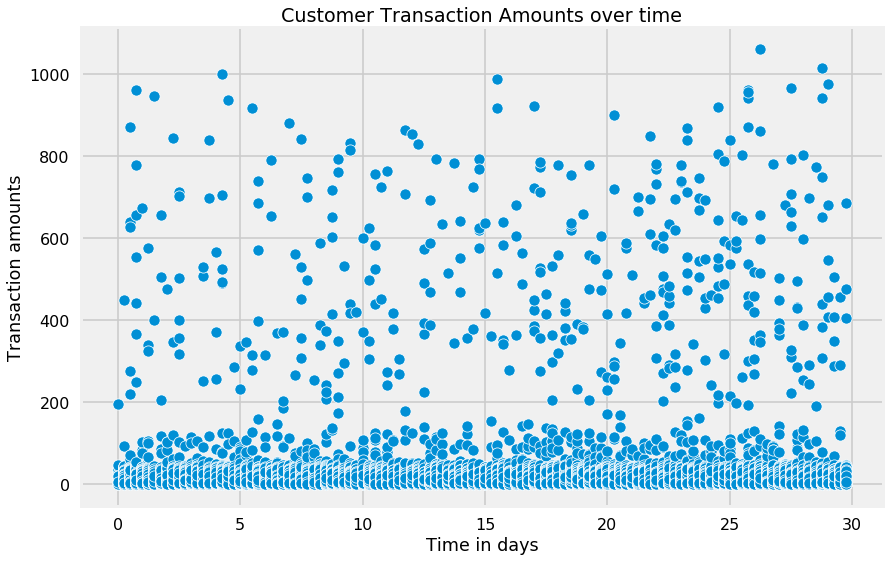

In [42]:
# transactions amount distribution
sns.scatterplot(x="time", y="amount", data=transactions)
plt.xlabel('Time in days')
plt.ylabel('Transaction amounts')
plt.title('Customer Transaction Amounts over time')
plt.show()

Most of the purchase amounts are under 100. However, there are lots of high value transactions with the max transaction amount being as high as 1062. We know from the portfolio data, that the most difficult offer requires the customer to spend 20 or more. So, the high value transactions that are way above 20 are probably group orders and not affected by the promotional offers. For our analysis and modeling purpose, we will mark these transactions as outliers by using the max threshold value from the [interquartile range](https://en.wikipedia.org/wiki/Interquartile_range). During an offer period, if a customer has one or more outlier transactions, we will not consider that as an effective offer for the customer.

In [43]:
def mark_outliers(trans_df):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest

    OUTPUT:
    df - a dataframe with missing values columns dropped
    cust_id_encoded - a dictionary with original and encoded customer id values
    '''
    Q3 = trans_df.amount.quantile(0.75)
    Q1 = trans_df.amount.quantile(0.25)
    IQR = Q3 - Q1
    max_value = Q3 + (1.5*IQR)
    min_value = Q1 - (1.5*IQR)
    max_value, min_value

    trans_df['outlier_trans'] = trans_df.amount.apply(
        lambda x: 1 if (x > max_value or x < min_value) else 0)

    print('Transaction amounts greater than {} are marked as outliers'.format(max_value))
    return trans_df

In [44]:
# Mark outlier transactions
transactions = mark_outliers(transactions)

Transaction amounts greater than 41.004999999999995 are marked as outliers


In [45]:
# Take a peek at cleaned transcript data
print('transactions data:')
print(transactions.head(2))
print('\n')
print('non-transactions data:')
print(non_transactions.head(2))

transactions data:
             event  time  amount  reward  cust_id  outlier_trans
12654  transaction   0.0    0.83     0.0       42              0
14557  transaction   0.0    7.75     0.0    11276              0


non-transactions data:
               event  time  offer_id  cust_id
0     offer received   0.0       4.0        4
9945  offer received   0.0       8.0    13469


Check if same offer was sent multiple times to a customer. This is done by checking if there are duplicate transactions for a customer,offer id and event combination. In these cases, we will consider only the first occurence of the offer.

In [46]:
# check number of duplicate transactions
non_transactions[non_transactions.event == 'offer received'].groupby(['cust_id', 'offer_id', 'event']).count()

time
cust_id offer_id event               
1       5.0      offer received     1
        6.0      offer received     1
        7.0      offer received     2
        10.0     offer received     1
2       3.0      offer received     1
...                               ...
16999   2.0      offer received     1
        4.0      offer received     1
17000   3.0      offer received     2
        6.0      offer received     1
        9.0      offer received     1

[63288 rows x 1 columns]

In [47]:
# check number of duplicate transactions
non_transactions[non_transactions.event == 'offer received'].duplicated(
    subset=['cust_id', 'offer_id', 'event']).sum()

12989

Next, we will merge all the datasets into a single dataframe.

Claning steps:

*    Convert non_transactions data to a [wide format](https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html) by creating separate columns for the events
*    From transactions data, calculate total amount spent by each customer during the 30 day promotional period. Exclude the outlier transactions from this calculation.
*    Merge all the datasets  into a single dataframe using the common customer and offer ids columns

In [48]:
def merge_data(trans_df, non_trans_df, portfolio_df, profile_df):
    '''
    Merges the three datasets
    INPUT:
    trans_df - a dataframe holding all the variables related to transaction data
    non_trans_df - a dataframe holding all the variables related to non transaction events
    portfolio_df - a dataframe holding all the variables related to various offers
    profile_df - a dataframe holding all the variables related to customers demographic data

    OUTPUT:
    merged_df - a dataframe holding merged data from all of the input data frames
    '''

    grouped_non_trans_df = non_trans_df.groupby(
        ['cust_id', 'offer_id', 'event']).min().unstack()
    grouped_non_trans_df.columns = grouped_non_trans_df.columns.map(
        lambda x: '{}_{}'.format(x[0], x[1])).str.replace(' ', '_')
    grouped_non_trans_df = grouped_non_trans_df.reset_index()

    trans_df = trans_df[trans_df.amount <= 41]
    grouped_trans_df = trans_df.groupby(
        ['cust_id']).amount.sum().reset_index()
    grouped_trans_df.rename(
        {'amount': 'total_amount_spent'}, axis=1, inplace=True)

    merged_df = grouped_non_trans_df.merge(
        grouped_trans_df, how='left', on='cust_id')

    merged_df = merged_df.merge(portfolio, how='inner', on='offer_id')
    merged_df = merged_df.merge(profile, how='inner', on='cust_id').sort_values(
        by=['cust_id', 'offer_id'])

    merged_df['total_amount_spent'].fillna(0, inplace=True)

    return merged_df

In [49]:
# Merge the datasets
data_merged = merge_data(transactions, non_transactions, portfolio, profile)

In [50]:
# Take a peek into the merged data
data_merged.head()

,cust_id,offer_id,time_offer_completed,time_offer_received,time_offer_viewed,total_amount_spent,reward,difficulty,duration,offer_type,mobile,social,web,gender,age,income,membership_duration
49964,2,3.0,NaN,21.0,NaN,77.01,0,0,4,informational,1,0,1,F,55,112000.0,376
49965,2,4.0,22.00,17.0,NaN,77.01,5,5,7,bogo,1,0,1,F,55,112000.0,376
52842,4,1.0,21.25,17.0,17.00,159.27,10,10,7,bogo,1,1,0,F,75,100000.0,443
52840,4,4.0,5.50,0.0,0.25,159.27,5,5,7,bogo,1,0,1,F,75,100000.0,443
52841,4,8.0,NaN,7.0,9.00,159.27,0,0,3,informational,1,1,0,F,75,100000.0,443


In [51]:
# check for number of customer and offer id combinations in the merged data set.
data_merged.shape

(55222, 17)

In [52]:
# Check for missing values
data_merged.isnull().sum()

cust_id                     0
offer_id                    0
time_offer_completed    27280
time_offer_received         0
time_offer_viewed       12729
total_amount_spent          0
reward                      0
difficulty                  0
duration                    0
offer_type                  0
mobile                      0
social                      0
web                         0
gender                      0
age                         0
income                      0
membership_duration         0
dtype: int64

Missing values for time_offer_completed and time_offer_viewed accounts for offers that were not viewed or completed by the customers.

**Identify Impacted customers**

Next, we will look at each promotional offer sent to customers and decide if the offer influenced if him or her. There are four broad categories based on customers’ response to the promotional offers.

* Influenced: The customer viewed the offer and completed it. The rule of thumb is if the customer was aware of the offer and then opt for it by completing it, then the offer influenced him. However, we will exclude those customer-offer combinations that meet this criterion but have outlier transactions during the offer period.
* Not influenced: If a customer viewed the offer but did not complete it, then he was not influenced by the offer. He knew of the offer but did not get influenced into making purchases.
* Completed without viewing: The customer completed an offer without viewing it or viewed it post-offer completion. Since he was not aware of the offer, he was not influenced by it. Probably he or she is a premium customer whose average spend is more than the regular ones irrespective of the promotional offers. Or it could just be a one-off high-value transaction by regular customers. Either way, it is different from the earlier two categories of customer-offer combination. We cannot conclude if the customer would have got influenced had he seen the offer. 
* Not viewed not completed - These are incomplete offers that the customers did not view or viewed after the expiry. Again, we cannot say anything conclusive about how the customer would have responded if he or she had viewed the offer.

It is worth mentioning, these are not groupings of customers, rather customer-offer combinations since the same customer can respond differently to different offers. Also, ideally we would clean up the data related to the third and fourth categories. But before that, we will plot the data for all the four categories and see how they compare with each other.
Another thing to note here is that, since informational offers were never completed, by default they will fall under the 'not influenced' category.

In [53]:
def derive_influenced(df):
    '''
    This function determines whether a patricular offer was effective in influencing the customer.
    It derives the influenced column value for each customer and offer id combination
    0 - not influenced. The customer viewed the offer but did not complete it. He was aware of the offer but did not get influenced
    1 - influenced. The customer was aware of the offer as he viewed the offer before completing it. 
    2 - completed w/o viewing. The customer completed the offer without viewing or viewed the offer post completion.
    3 - not viewed not completed. The customer did not view or was not aware of the offer and did not complete the offer. 

    INPUT:
    df - a dataframe holding all the variables of interest

    OUTPUT:
    df - a dataframe with the influenced column populated with either of the four values
    '''

    # Create the progressbar
    cnter = 0
    widgets = ['Completion Percentage: ', Percentage(), ' ', Bar(
        marker='0', left='[', right=']'), ' ', ETA(), ' ', FileTransferSpeed()]  # see docs for other options

    pbar = ProgressBar(widgets=widgets, maxval=len(df))
    pbar.start()

    df['time_offer_expired'] = df['time_offer_received'] + df['duration']
    df['offer_viewed'] = df.time_offer_viewed.apply(
        lambda x: 0 if np.isnan(x) else 1)
    df['offer_completed'] = df.time_offer_completed.apply(
        lambda x: 0 if np.isnan(x) else 1)

    for i, item in df.iterrows():
        cnter += 1
        pbar.update(cnter)

        outlier_trans = 0
        influenced = 0
        discard = 0

        cust_id = item['cust_id']
        time_offer_received = item['time_offer_received']
        time_offer_viewed = item['time_offer_viewed']
        time_offer_expired = item['time_offer_expired']
        time_offer_completed = item['time_offer_completed']
        offer_viewed = item['offer_viewed']
        offer_completed = item['offer_completed']

        if offer_completed == 1:
            outlier_trans_amount = transactions.query(
                'cust_id==@cust_id and time>=@time_offer_received and time<=@time_offer_completed and outlier_trans == 1')['amount'].sum()
            # For effective offers only consider those offers which did not have outlier transactions during the offer period
            if outlier_trans_amount > 0:
                discard = 1
            else:
                # Not an effective offer if the customer completed the offer without viewing or viewing after completion
                if offer_viewed == 0 or time_offer_viewed > time_offer_completed or time_offer_viewed > time_offer_expired:
                    influenced = 2
                else:
                    influenced = 1
        else:
            # Can't determine effectivenedd of the offer if it was not viewed or was viewed after the expiry
            if offer_viewed == 0 or time_offer_viewed > time_offer_expired:
                influenced = 3
            else:
                influenced = 0

        df.loc[i, 'discard'] = discard
        df.loc[i, 'influenced'] = influenced

    pbar.finish()

    df = df[df.discard != 1]
    df.influenced = df.influenced.astype(int)

    return df

In [54]:
# Derive effectiveness of the customer-offer combinations
data = derive_influenced(data_merged)

Completion Percentage: 100% [000000000000000000000000] Time:  0:04:19 213.0 B/s


In [55]:
# Check the counts for different categories
data.influenced.value_counts()

1    19326
0    17858
3     9422
2     8071
Name: influenced, dtype: int64

## Data Analysis

In this section, we will perform Data analysis to derive some critical insights into the data as well as find answers related to relevant business questions.

We will plot some of the customers and offer attributes to develop an intuition about how these influence customer behavior in responding to the promotional offers. During our visual analysis of these plots, we will ignore the trends for informational offers. 

_**Categorical features**_

For Categorical features, we will judge the influence by comparing the response ratio(influenced vs not influenced) for various categories. 

In [56]:
def group_count_plot(df, groupby_col):
    '''
    INPUT:
    data - a dataframe holding all the variables of interest
    groupby_col - column name to be used for grouping values
    agg_col - column name for values to be grouped

    OUTPUT:
    Plot to display grouped values of customers
    '''
    grouped_df = df.groupby(groupby_col)['cust_id'].count()
    order_index = data[data.influenced.isin(['0', '1'])].groupby(
        groupby_col)['influenced'].mean().sort_values(ascending=False).index

    splot = sns.countplot(x=groupby_col, data=df, hue='influenced',
                          palette="Set1", order=order_index)
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), (p.get_x()+p.get_width()/2., p.get_height()),
                       rotation=90, ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')

    plt.xlabel(groupby_col.replace('_', ' ').title())
    plt.ylabel('Customers count')

    plt.title(" Customers count by {}".format(
        groupby_col.replace('_', ' ').title()), fontsize=18, fontweight='bold')

    plt.show()

**Offer type**

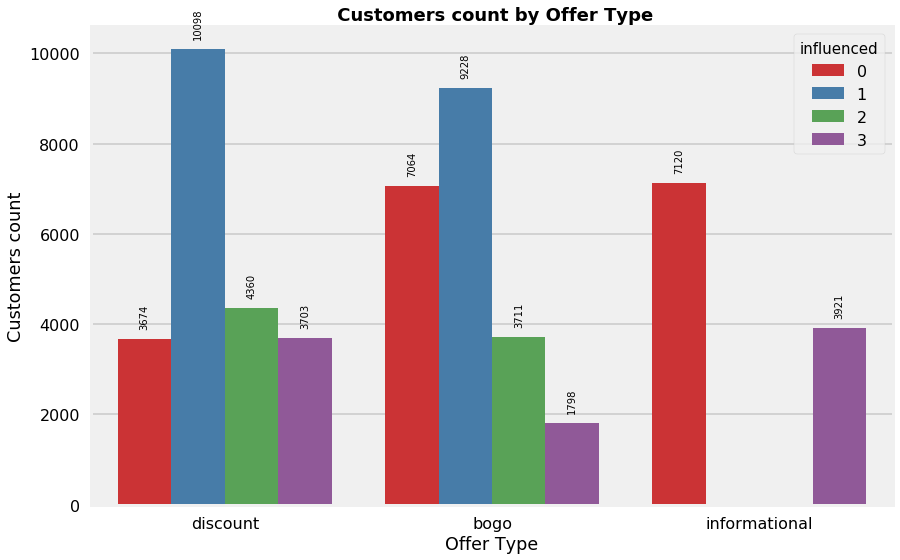

In [57]:
group_count_plot(data, 'offer_type')

* Discount offers had better success rate than BOGO. 

**Offer Id**

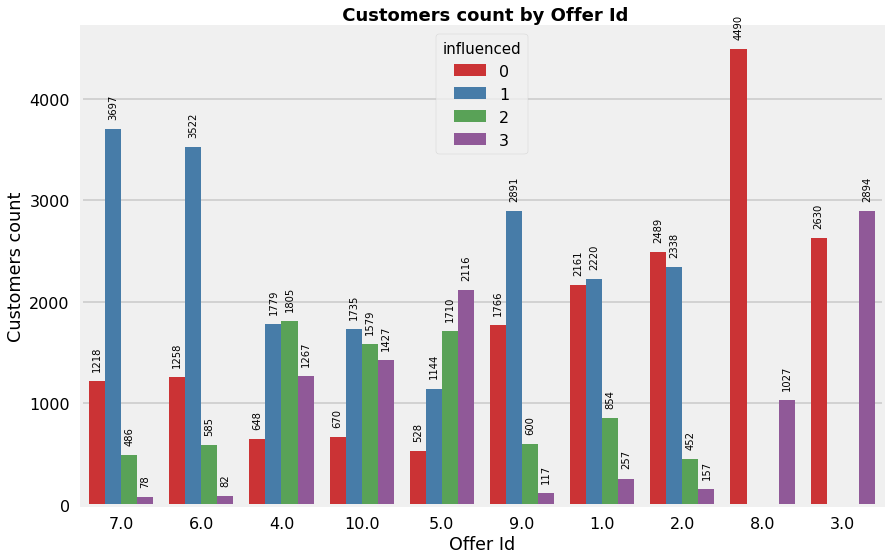

In [58]:
group_count_plot(data, 'offer_id')

* Based on customer response ratio, offer ids 7,6 and 4 respectively are the top 3 offers.
  Here are the details for these offers.
  6 - Spend 7 dollars within 7 days and get 3 dollars as discount.
  7 - Spend 10 dollars within 10 days and get 2 dollars as discount.
  4 - Spend 5 dollars within 7 days and get 5 dollars worth of product free.

* An interesting thing to note here is that the BOGO offers with same difficulty(offer ids 1 and 2) as offer id 7 did not get the same response. It seems customers preferred to buy the product at a discounted amount than getting an extra product for free.

**Difficulty**

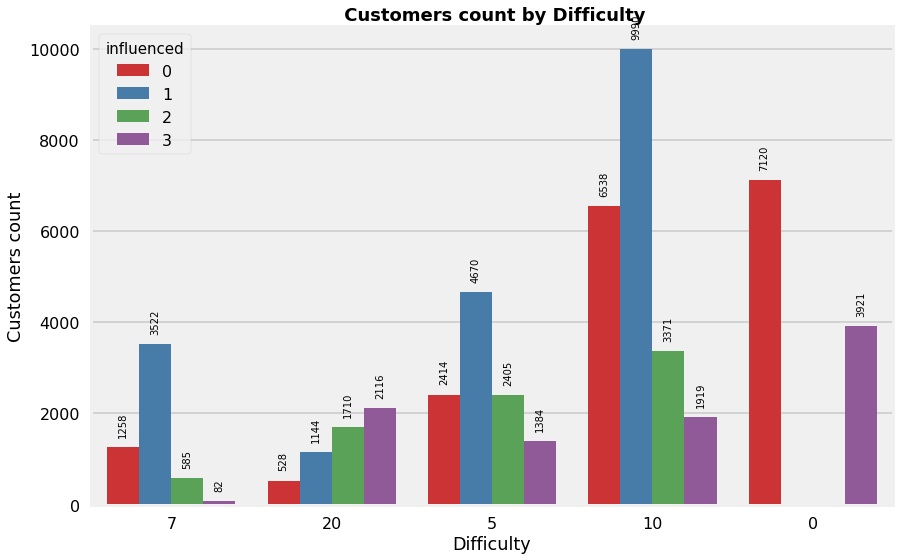

In [59]:
group_count_plot(data, 'difficulty')

* Offers with difficulty level 7 had the best response ratio.
* For the offer with the highest difficulty level, most of the offers were not viewed by the customer. However, there is no clear correlation between difficulty level and response ratio.

**Duration**

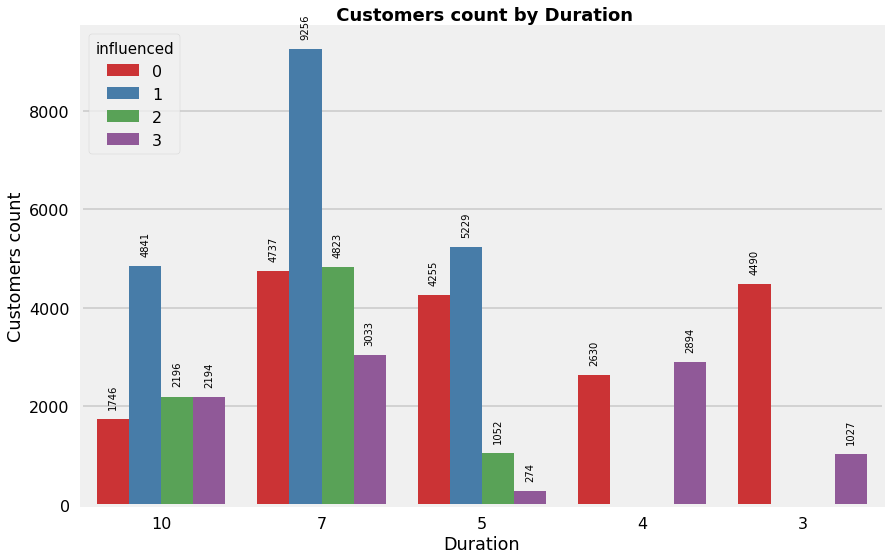

In [60]:
group_count_plot(data, 'duration')

Offers with longer duration had better success rate.

**Gender**

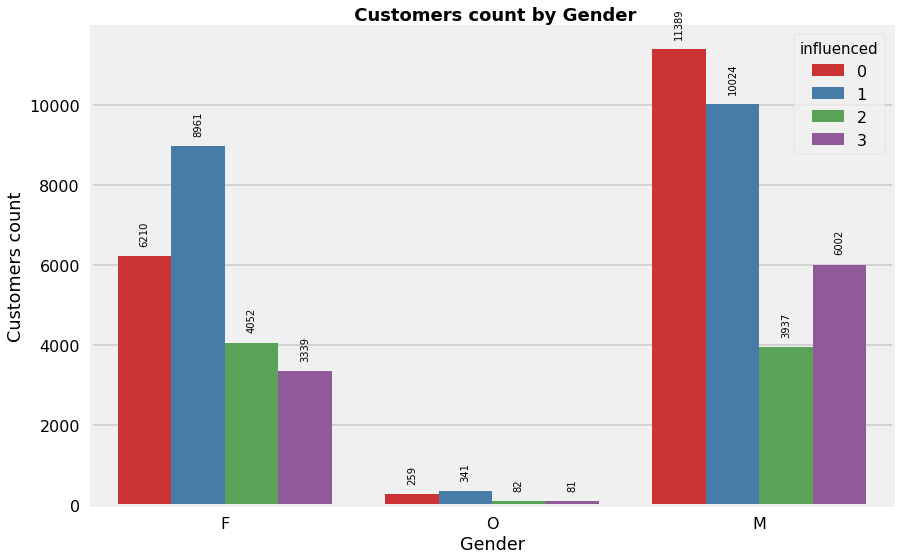

In [61]:
group_count_plot(data, 'gender')

* Females have better response ratio than their male counterparts. 
* Although, there were comparatively lesser no of customers belonging to 'Other' gender, their response ratio was better than the males.

_**Numerical features**_

Next, we will explore the influence of Numerical features in successful offers.
For this, we will compare the distribution of the feature for responsive and not responsive offers.

In [62]:
def group_box_plot(df, groupby_col, agg_col):
    '''
    INPUT:
    groupby_col - column name to be used for grouping values
    agg_col - column name for values to be grouped

    OUTPUT:
    Plot displaying the grouped values

    '''
    grouped_df = df.groupby(groupby_col)[agg_col].mean()
    order_index = grouped_df.sort_values(ascending=True).index
    ss = sns.boxplot(x=groupby_col, y=agg_col, data=df, hue='influenced',
                     palette="Set1", order=order_index)
    plt.xlabel(groupby_col.replace('_', ' ').title())
    plt.ylabel(agg_col.replace('_', ' ').title())
    plt.title(" {} distribution by {}".format(agg_col.replace('_', ' ').title(),
                                              groupby_col.replace('_', ' ').title()), fontsize=18, fontweight='bold')

    plt.xticks(
        rotation=45,
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large'
    )
    plt.show()

**Total Amount Spent**

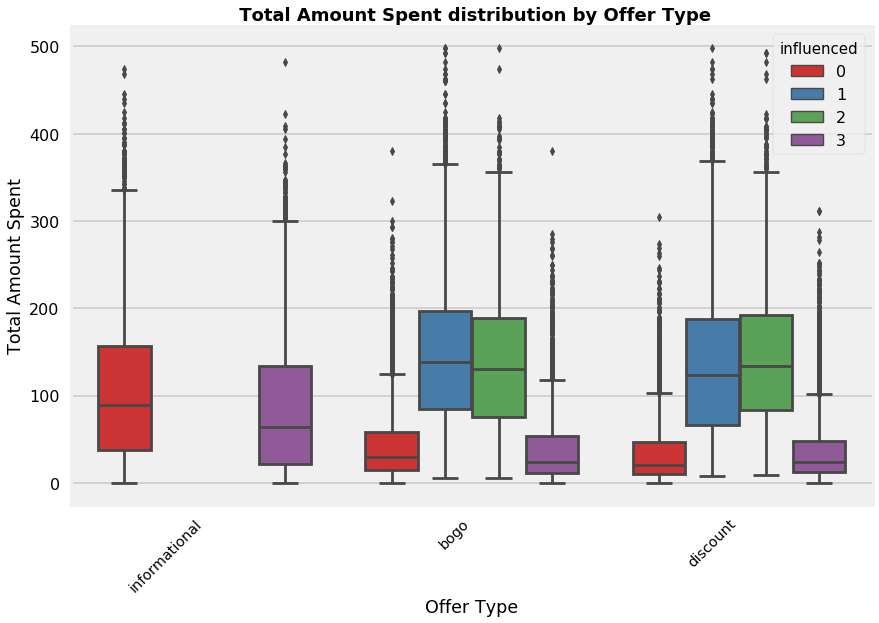

In [63]:
group_box_plot(data, 'offer_type', 'total_amount_spent')

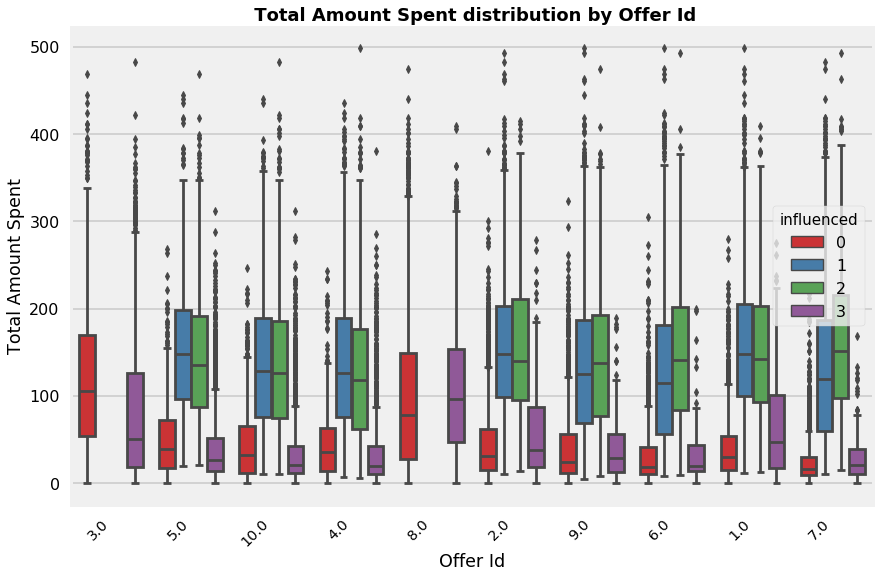

In [64]:
group_box_plot(data, 'offer_id', 'total_amount_spent')

* The customers who were influenced by the offers, spent significantly more per hour on average than the ones who did not respond. Which is on expected lines. 
* The total spent amounts were almost always under 200 dollars.
* There seems to be two broad categories. Those who completed the offers(category 1 and 2) have similar distributions of total amounts spent, as do the segments which did not complete the offers(category 0 and 3).
* And there is no clear trend to demarcate the viewed and non viewed segments from one another. Let's see if this holds true for other customer attributes like age, income and membership duration.

**Income**

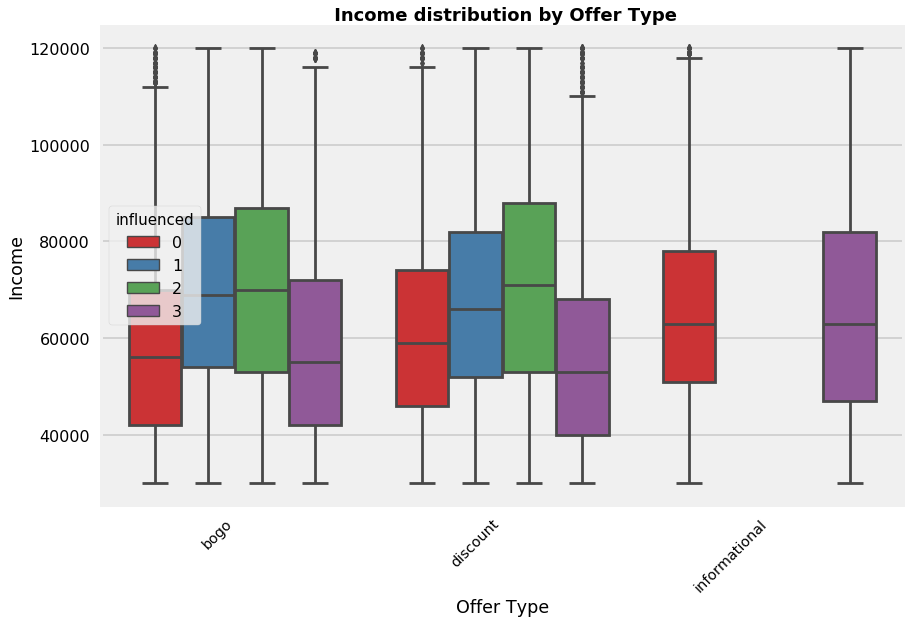

In [65]:
group_box_plot(data, 'offer_type', 'income')

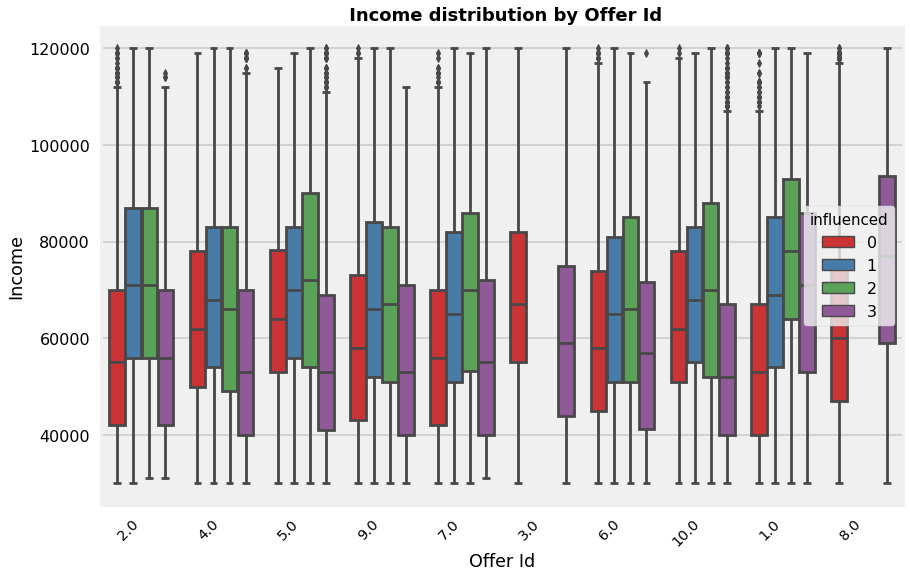

In [66]:
group_box_plot(data, 'offer_id', 'income')

* Most of the offers were sent to customers belonging to 40-80k income bracket. 
* Across the offers the influenced segment belongs to higher income group than their non-influenced counterparts.* It is safe to surmise that customers belonging to higher income group, are more likely to respond to the promotional offers, irrespective of the offer variety.
* Just like 'total amounts spent' , segments 1 and 2 share similarity as do segments 0 and 3. The similarities are less profound than what was seen for 'total amounts spent'.
* Unlike 'total amounts spent' there is no clear separation between completed and not completed segments.

**Age**

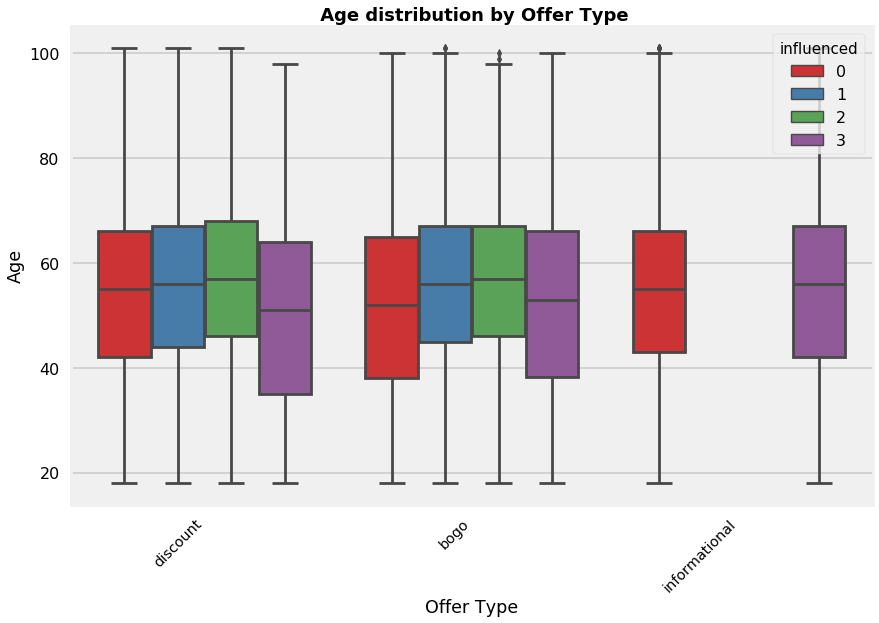

In [67]:
group_box_plot(data, 'offer_type', 'age')

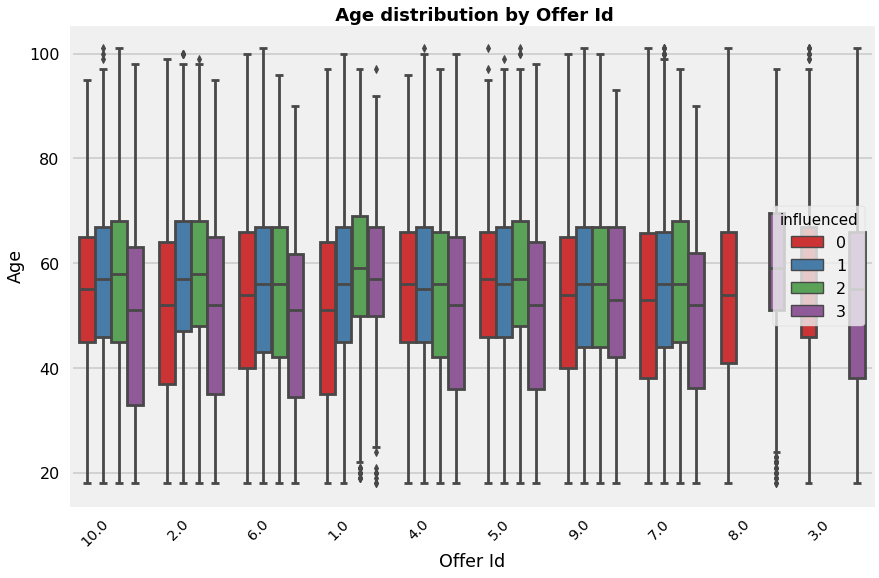

In [68]:
group_box_plot(data, 'offer_id', 'age')

* Most of the offers were sent to 40 to 70 year old customers.
* The separation between different segments is not as profound for 'age' distribution as it was for income and total amount spent. However, category 3 seems to always belong to lower age group as compared to the rest of the categories.

**Membership duration**

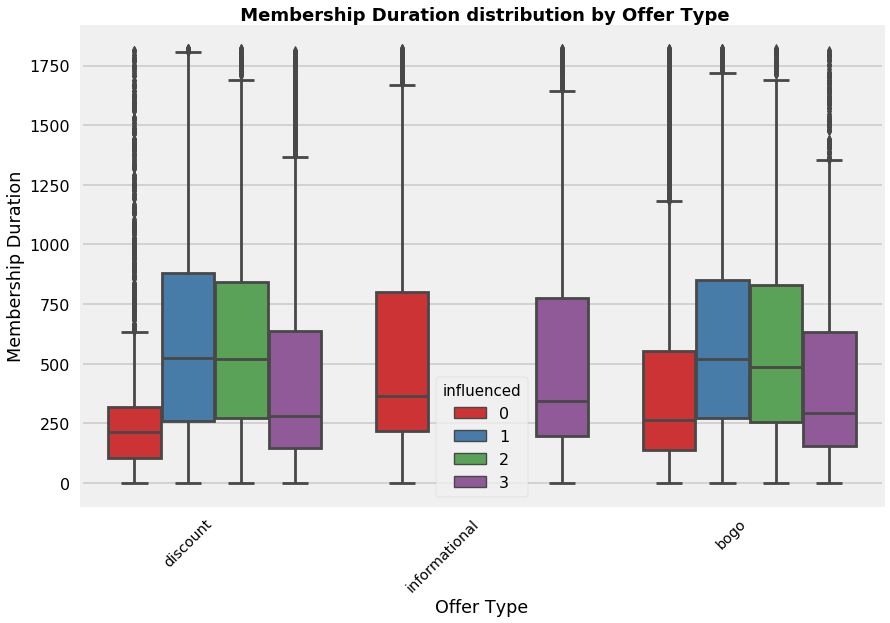

In [69]:
group_box_plot(data, 'offer_type', 'membership_duration')

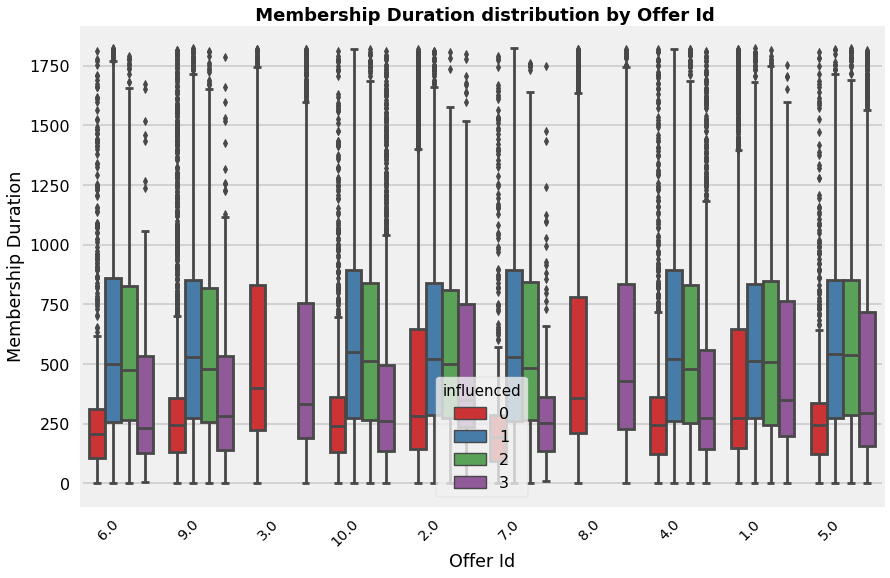

In [70]:
group_box_plot(data, 'offer_id', 'membership_duration')

*	Most of the offers were sent to customers with less than 2 years of membership.
*	On average, customers who responded to the offers have been member for a longer time than the one who did not. 
*  Membership duration does a good job of separating the different segments. It appears to be an important feature for determining customers likelihood of response to an offer.
*   Also, trend seen in 'amount spent per hour' seem to more or less hold true here as well, i.e., categories 1 and 2 share similarity. As does the categories 0 and 3. However, category 3 has wider distribution of membership than category 0.


**Difficulty**

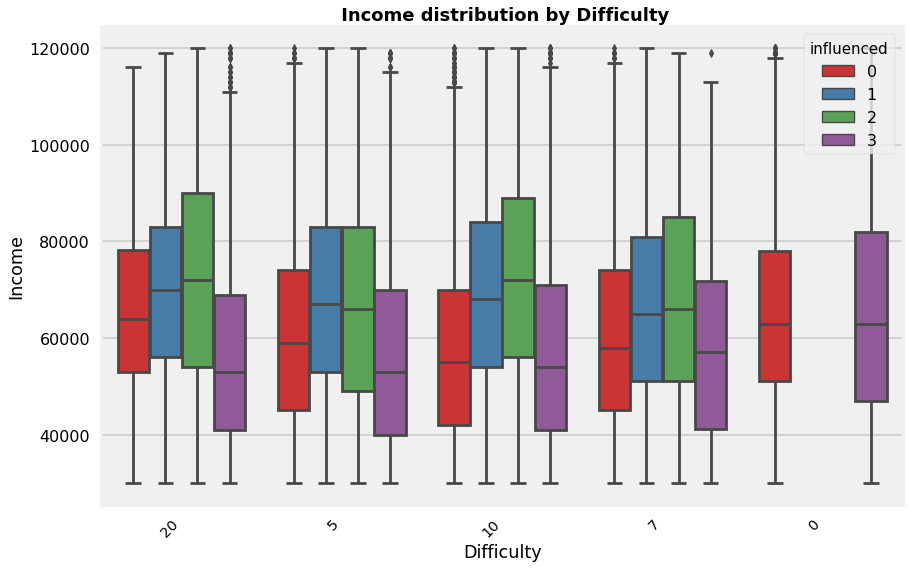

In [71]:
group_box_plot(data, 'difficulty', 'income')

Irrespective of the difficulty level of the offers, customers with high income groups, responded better than  the customers with lower incomes.

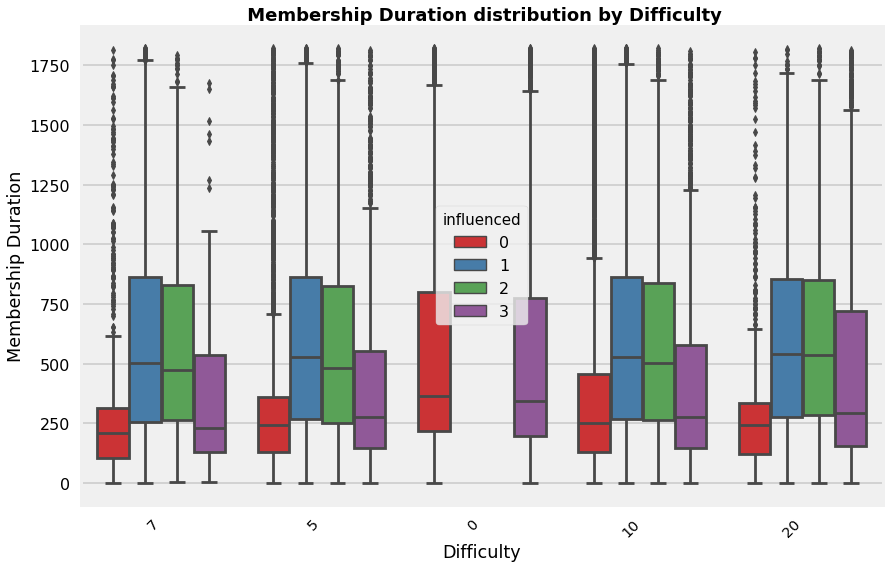

In [72]:
group_box_plot(data, 'difficulty', 'membership_duration')

Irrespective of the offer difficulty, customers that have been members for longer time, responded better than rest.

Extending from the above visualizations, we will create some features that will segregate the continuous features like age,income and membership duration to various demographic groups. This will help us compare different demographic groups and their response ratio to the offers.


In [73]:
def create_features(df):
    '''
   Create additional features from existing features
   INPUT:
   df - a dataframe holding all the variables of interest

   OUTPUT:
   Plot to display grouped values
   '''
    df['difficulty_ratio'] = round(df['difficulty'] / df['duration'],2)

    age_bins = [1.0, 21.0, 41.0, 61, 81.0, 120.0]
    age_groups = ['<20', '21-40', '41-60', '61-80', '80+']
    df['age_bins'] = pd.cut(df['age'], age_bins,
                            labels=age_groups, right=False)

    income_bins = [0, 40001, 60001, 80001, 100001, 120001]
    income_groups = ['<=40k', '40-60k', '60-80k', '80-100k', '100k+']
    df['income_bins'] = pd.cut(
        df['income'], income_bins, labels=income_groups, right=False)

    membership_bins = [0, 365, 900, 1500, 2000]
    membership_groups = ['0-365', '365-900', '900-1500', '1500-2000']
    df['membership_spans'] = pd.cut(
        df['membership_duration'], membership_bins, labels=membership_groups, right=False)

    return df

In [74]:
data = create_features(data)

**Difficulty ratio**

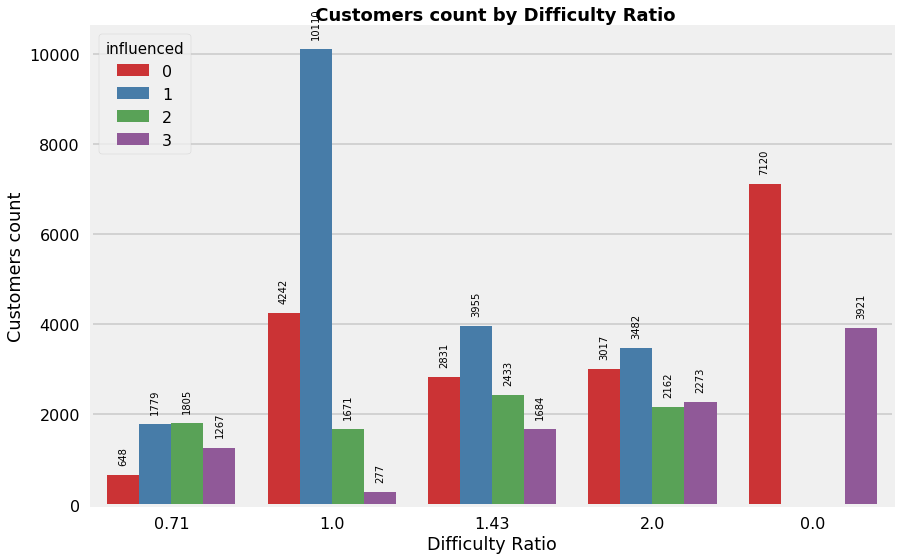

In [75]:
group_count_plot(data, 'difficulty_ratio')

Offers with lower difficulty ratio seems to have better response rate. The exception to this is information offers with difficulty ratio 0. This is expected since we don’t have a methodology yet to measure response rate for informational offers and by default these offers are marked as non-responsive.

**Income groups**

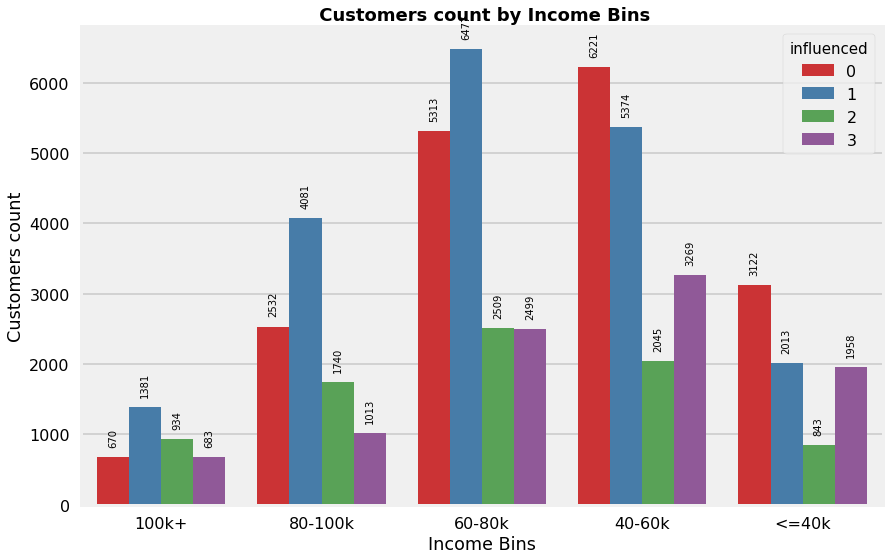

In [76]:
group_count_plot(data, 'income_bins')

* The response ratio was best for customers in the 100k+ income bracket,  followed by the customers in the 80-100k income bracket.
* Positive correlation of income and customer's response is apparent from the above visualization. We can safely infer that people with income greater than 60k are more likely to respond to the offers.

**Membership spans**

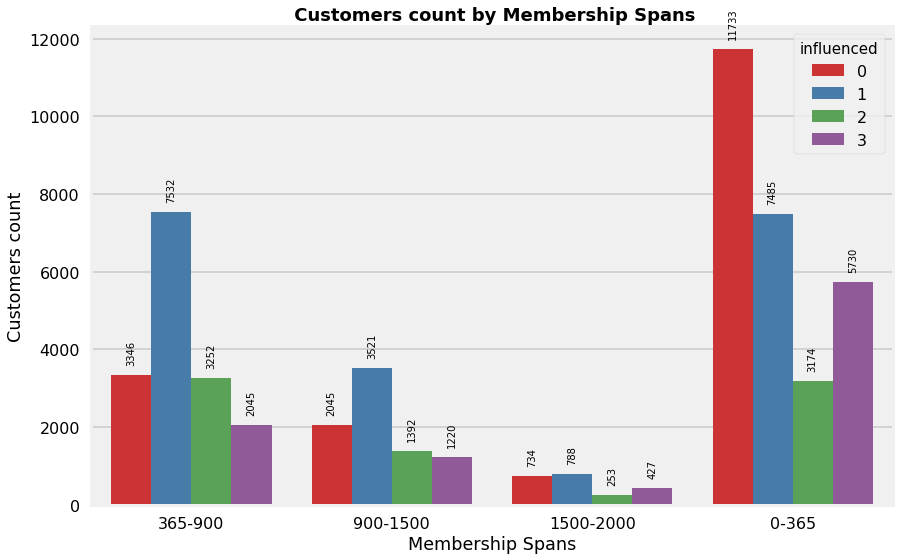

In [77]:
group_count_plot(data, 'membership_spans')

* The most responsive customers are the one who have been members for 1 to 2.5 years(365-900 days), followed by those with 2.5-4 years of membership. 
* After reaching a high around 1-2.5 years of membership, response rate  decreases continually with increase in membership duration.

**Age groups**

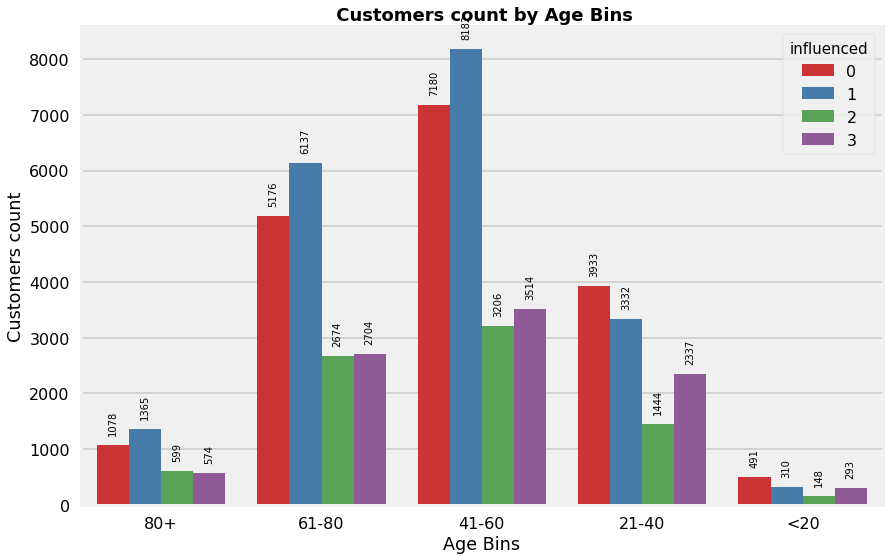

In [78]:
group_count_plot(data, 'age_bins')

* The response ratio was best for customers in the 80+ age group,  followed by the customers in the 61-80 age group.
* There is a positive correlation between age and customer's response. Older customers seem to have a better response ratio than their younger counterparts. 
* It is probably safe to infer that customers who older than 40 are more likely to respond to the offers.

# Modelling and Evaluation

In this part we will build a predictive model that will predict if a customer  is likely to respond to an offer. Since, sending offers costs the organization, we don't want to send offers to customers who are not likely to respond. Also, we don't want to miss out on sending offers to the customers who are actually going to respond. As we need to optimize both precision and recall, we will use F1 score as the model evaluation metric.

**Select features for predictive model**

As a first step, we need to select only relevant features for the model.
Our goal is to build a predictive model that classifies if a customer and offer id combination is effective or not based on customer’s demographic data and offer attributes. We will drop everything related to transactions data including ‘total amount spent’. Though, ‘total amount spent’ does a good job of separating ‘influenced’ and ‘not influenced’ categories, including it as an independent feature will cause [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/).

Also from the EDA section, it is safe to surmise that there is no clear trend that separates category 2 from the other categories. Though category 1 and 2 share similarities, we can’t merge them because there may be some high-value customers inside category 2 who on average spend more than regular customers. Sending offers to these customers will not help us since they will make the purchases, anyway. We can’t merge category 2 with the ‘not influenced’ group because there is no similarity between the two groups.

However, categories 0 and 3 can be merged as they share similar traits. It is okay to not send offers to customers who did not view the offer and are most likely not going to respond even after viewing.

In [79]:
def select_features(df):
    '''
    Selects the final list of features to be used for modeling

    INPUT: Dataframe with all variables of interest
    OUTPUT: Dataframe with selected features for predictive model. And two class target variable.
    '''
    # Merge category 0 and 3
    df.replace(3, 0, inplace=True)
    # Clean category 2 data
    df = df[df.influenced != 2]
    df = df.drop(['cust_id', 'time_offer_received', 'time_offer_expired', 'time_offer_viewed', 'time_offer_completed',
                  'total_amount_spent', 'offer_completed', 'offer_viewed', 'discard', 'age_bins', 'income_bins', 'membership_spans', 'difficulty_ratio'], axis=1)

    return df

In [80]:
data = select_features(data)

In [81]:
# Count of different category values 
data.influenced.value_counts()

0    27280
1    19326
Name: influenced, dtype: int64

The dataset seems to be imbalanced. One more reason to go with F1 score as the evaluation metric.

_**Naive predictor**_

Let's start by build a naive classifier that randomly classifies customer and offer id combinations to 'influenced' and 'not influenced'
This is simply to show how a base model without any intelligence would perform. We can use this to compare performance of the machine learning algorithm we will be building.

In [82]:
y_actual = data.influenced
# Run a simulation for 500 times
for i in range(500):
    
    f1_scores = []
    y_pred = []

    for i in range(data.shape[0]):
        random_no = np.random.rand()
        #for each row randomly predict if the offer is effective
        if random_no >= 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)

    # Calculate F-score
    fscore = f1_score(y_actual, y_pred, average='micro')

    f1_scores.append(fscore)

# Print the results
print("Naive Predictor: [F-score: {0:.2f}]".format(np.mean(f1_scores)))

Naive Predictor: [F-score: 0.50]


It seems if we distribute the offers randomly, there is 50% chance of having a successful offer.

**Prepare data**

Many machine learning algorithms work better when features are on a relatively similar scale and close to normally distributed. Also, it is better to [one-hot-encode](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) categorical features to avoid introducing ordinality in nominal variables among other reasons.

For our initial model, we will not apply the numerical transformation. Later on, we will explore this option for improving model performance.

In [83]:
def transform_data(df):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest

    OUTPUT:
    transformed_df - dataframe after data preprocessing
    '''

    transformed_df = df.copy()
    cat_cols = ['offer_id', 'offer_type', 'gender']

    for col in cat_cols:
        transformed_df[col] = transformed_df[col].astype('category')
        #one hot encode the categorical variables
        transformed_df = pd.concat([transformed_df.drop(
            col, axis=1), pd.get_dummies(transformed_df[col], prefix=col)], axis=1)

    return transformed_df

In [84]:
transformed_data = transform_data(data)

In [85]:
# Split the predictor and target variables 
target = transformed_data['influenced']
features = transformed_data.drop(['influenced'], axis=1)

We will consider following supervised models and see which one generalizes best to the dataset:
* Logistic Regression
* Ada Boost
* Random Forest
* Light GBM

For each of these models, we will use 5 fold Cross-Validation to see how the model score varies on different subsets of data. For now, we will leave the model parameters at the default settings.

In [86]:
def evaluate_models(features, target, test_size=0.2):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest

    OUTPUT:
    Plot showing comarison of model scores
    '''
    # prepare configuration for cross validation test harness
    seed = 7

    # evaluate each model in turn
    results = []
    names = []
    scoring = 'f1_micro'

    for name, model in models:
        start = time()  # Get start time
        kfold = StratifiedKFold(n_splits=5, random_state=seed)
        cv_results = cross_val_score(
            model, features, target, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)

        msg = "%s: Mean validation score: %0.2f (std %0.4f)" % (name, cv_results.mean(), cv_results.std())
        #Mean validation score:
        print(msg)
        end = time()  # Get end time
        print('time taken', end-start)

    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison', fontsize=18, fontweight='bold')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

ADA: Mean validation score: 0.78 (std 0.0054)
time taken 7.866098403930664
LR: Mean validation score: 0.74 (std 0.0161)
time taken 3.178908348083496
RF: Mean validation score: 0.76 (std 0.0047)
time taken 2.0742666721343994
LGBM: Mean validation score: 0.79 (std 0.0048)
time taken 2.726235866546631


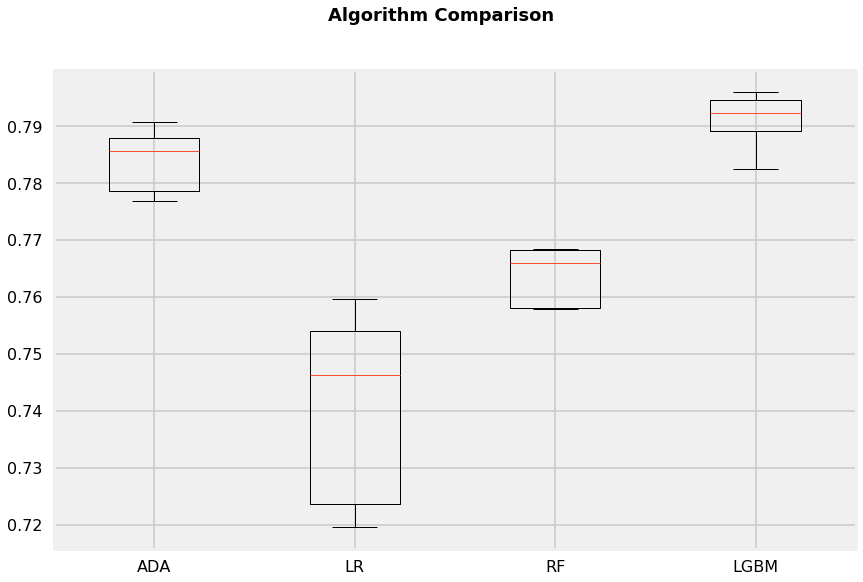

In [87]:
# Compare models
models = []
models.append(('ADA', AdaBoostClassifier(random_state=42)))
models.append(('LR', LogisticRegression(random_state=42)))
models.append(('RF', RandomForestClassifier(random_state=42)))
models.append(('LGBM', LGBMClassifier(random_state=42)))

evaluate_models(features, target, models)

LightGBM is the winner here. It has the best average Cross-Validation score and the low standard deviation value for the cross-validation scores indicate stability of the model.

**Feature Importance and Model Explainability**

We will check the feature importance of the model [permutation importance](https://www.bmc.com/blogs/scikit-learn-permutation-importance/). It determines the weight of the input variables by checking how much model outcome changes by dropping the variable or shuffling the rows.

In [88]:
# Split the data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42)

In [89]:
lgb=LGBMClassifier(random_state=1)
lgb.fit(X_train, y_train)
perm = PermutationImportance(lgb, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.1715 ± 0.0057,difficulty
0.0823 ± 0.0048,membership_duration
0.0395 ± 0.0071,income
0.0198 ± 0.0030,reward
0.0114 ± 0.0014,gender_M
0.0112 ± 0.0010,social
0.0098 ± 0.0020,age
0.0012 ± 0.0014,offer_id_7.0
0.0012 ± 0.0014,offer_id_9.0
0.0011 ± 0.0010,duration


Offer difficulty, membership duration, income, reward and gender seem to be most important features.

Next, we will look at a sample prediction using [lime](https://://github.com/marcotcr/lime) to interpret how the model makes prediction.

In [90]:
def interpret_predictions(idx):
    '''
    INPUT - Index value from validation dataset
    OUTPUT - Plot displaying input data and how they contributed in model prediction
    '''
    explainer = lime.lime_tabular.LimeTabularExplainer(X_test.astype(int).values,
                                                       mode='classification', training_labels=y_test, feature_names=X_test.columns)
    # asking for explanation for LIME model
    exp = explainer.explain_instance(X_test.loc[idx].astype(
        int).values, lgb.predict_proba, num_features=6)
    exp.show_in_notebook()
    exp.as_pyplot_figure()
    plt.show()

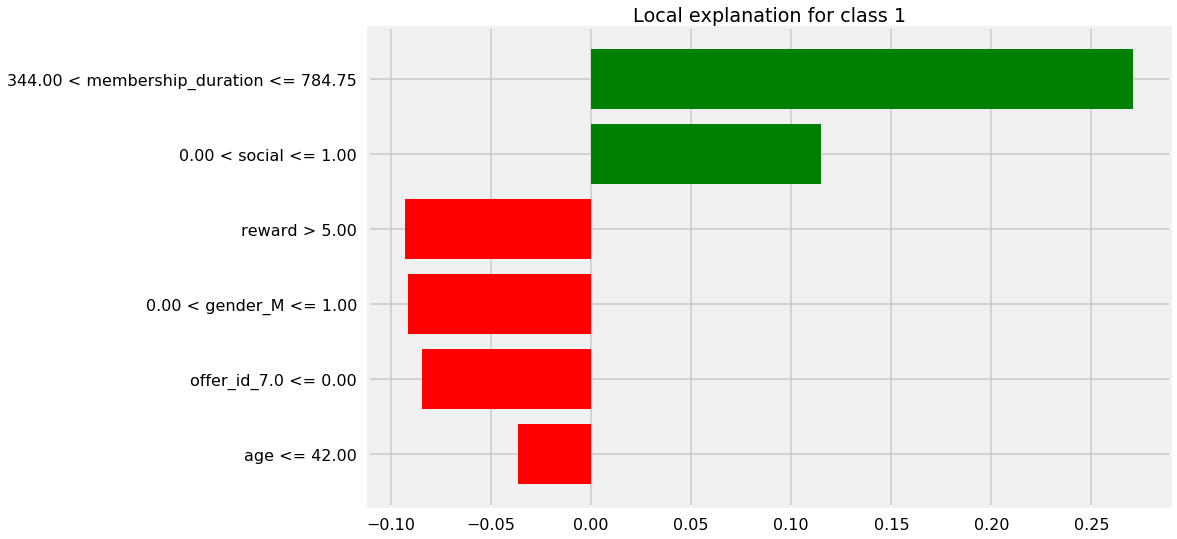

In [91]:
# Get explanation for a sample row from validation test
interpret_predictions(X_test.index[4])

The decision process seems to more or less confirm the intuition we developed during EDA phase.

**Performance tuning**

In this section, we will try to improve upon the model score further by [tuning the LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) model's parameters using RandomizedSearchCV.

* num_leaves: This is the main parameter to control the complexity of the tree model. Large value for num_leaves helps improve accuracy but might lead to over-fitting. To prevent that, we should let it be smaller than 2^(max_depth).
* min_data_in_leaf: Its optimal value depends on the number of training samples and num_leaves. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.
* max_depth: max_depth is used to limit the tree depth explicitly.
* boosting_type: 'dart' usually gives better accuracy

In [93]:
# build a classifier
clf = make_pipeline(RobustScaler(), LGBMClassifier(random_state=42))

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.2f} (std: {1:.2f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters 
param_dist = {
    'lgbmclassifier__learning_rate': [0.05, 0.01],
    'lgbmclassifier__num_leaves': [6,18,36,52], 
    'lgbmclassifier__boosting_type' : ['gbdt', 'dart'],
    'lgbmclassifier__max_depth': [5,10,15, None],
    'lgbmclassifier__min_data_in_leaf': [20, 30, 50, 100]}

# run randomized search
kf = StratifiedKFold(n_splits=5)
n_iter_search = 60
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, scoring="f1_micro",
                                   cv =kf, n_jobs=-1,verbose=1, iid=False)

start = time()

random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.9min finished


RandomizedSearchCV took 116.98 seconds for 60 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.80 (std: 0.00)
Parameters: {'lgbmclassifier__num_leaves': 52, 'lgbmclassifier__min_data_in_leaf': 50, 'lgbmclassifier__max_depth': 15, 'lgbmclassifier__learning_rate': 0.05, 'lgbmclassifier__boosting_type': 'gbdt'}

Model with rank: 2
Mean validation score: 0.80 (std: 0.00)
Parameters: {'lgbmclassifier__num_leaves': 36, 'lgbmclassifier__min_data_in_leaf': 20, 'lgbmclassifier__max_depth': None, 'lgbmclassifier__learning_rate': 0.05, 'lgbmclassifier__boosting_type': 'gbdt'}

Model with rank: 3
Mean validation score: 0.80 (std: 0.00)
Parameters: {'lgbmclassifier__num_leaves': 36, 'lgbmclassifier__min_data_in_leaf': 30, 'lgbmclassifier__max_depth': None, 'lgbmclassifier__learning_rate': 0.05, 'lgbmclassifier__boosting_type': 'gbdt'}



We are able to optimize the to achieve a better score(.80) as compared to the initial model(0.79) with default parameters.
And if we compare this with the naive predictor's score , there is a huge increase in prediction capabilities.
Using this model can significantly improve our chances of a successful offer than just randomly distributing the offers.

# Conclusions

Reflections:
* Cleaning up transcript data was one of the most challenging aspect of this project.
* The difficulty level and reward amount of offers along with membership duration, income, and age of customers are the most important features that determine the chances of offer success.
* Discount offers type, longer duration, lesser difficulty level are some of the offers attribute that increases probability of a successful offer.
* Some of the customers attribute that increases response probability are higher income(>60 k), longer membership(sweet spot is in 1 to 2.5 years range), female gender and higher age(>40 years).

Scope for Improvement:
* There are still scope for improving the model performance further by the following strategies. We can simply try out other high performance models like XGboost, Catboost to see if they perform better. Another common strategy used for improving model performance is [Stacking](https://www.kdnuggets.com/2017/02/stacking-models-imropved-predictions.html) a bunch of models together. Also, this one being an imbalanced dataset, another option that we can certainly explore  [SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html) to oversample data from the minority class.
* Using transaction data for predicting customer's responses would result in data leakage. However, historical data related to customers' purchase amounts can help us in predicting if a  customer is going to respond to an offer or not. For instance, if a customer's average spending is much more than the regular customer, sending the low difficulty offers to them does not make much of a business sense. We would rather send the high difficulty offers to them. Also, with the current data, it is difficult to judge if informational offers had any influence. A comparison of the customer's historical average spending rate with the offer period average spending rate would have helped us determine the effect of informational offers.
* There are lots of cases where customers availed of the offer without viewing it. From a business perspective, we would ideally want to avoid sending those offers. During our analysis, we could not find attributes that can help predict this segment of customers. However, a way around would be to make the offers coupon-based. That way only the customers wanting to avail the offers would be able to complete the offers.
* Since all offers were not sent to all the users, we can create a data set by mapping all offers to all customers and then predict customer's responses for each of the offers. If a customer is likely to respond to multiple offers, we need to pick only the ones which bring maximum business, for instance, the offers with the highest difficulty or the lowest reward ratio.